<a href="https://colab.research.google.com/github/yedini/DL_tensorflow/blob/main/Part2_Lab05_Dropout_%26_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overfitting: train set에 과도하게 잘맞아서 test set에는 오히려 잘 안맞는 경우.

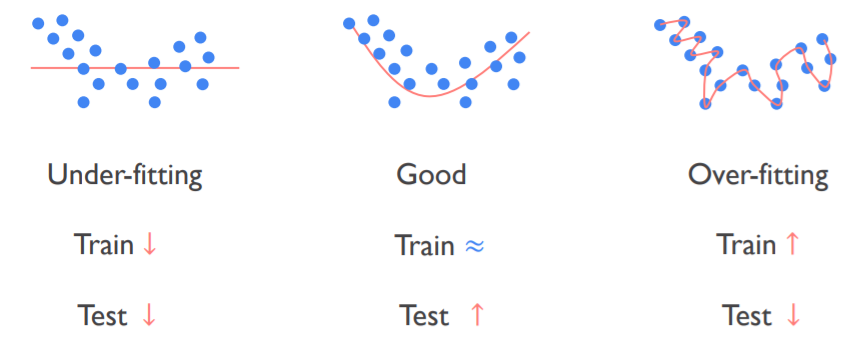

#### Dropout       
네트워크의 모든 노드를 활용하지 않고, 일부 노드를 끈 채로 나머지 노드들을 학습하는 것.      
어떤 노드를 끌지는 랜덤으로 정해짐      
이후 test set에서는 모든 노드를 활용함.

#### Batch Normalization    
- Internal Covariate Shift : 데이터가 layer들을 지나가면서 처음에 가졌던 분포가 망가지는 현상. -> 학습에 문제가 생김        
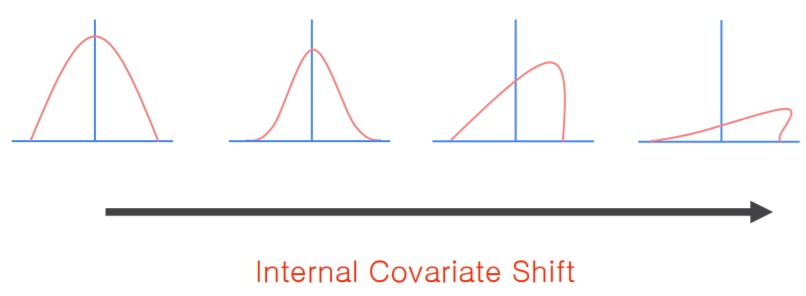
- Batch Normalization :Interval covariate shift를 막기 위해 각 layer 층으로 들어오는 input data를 계속 normalization을 시켜서 항상 일정한 분포를 갖게 함.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from time import time
import os
print(tf.__version__)

#### Checkpoint function / Data load & pre-processing function    
relu activation 코드와 동일

In [ ]:
def load(model, checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt :
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        checkpoint = tf.train.Checkpoint(dnn=model)
        checkpoint.restore(save_path=os.path.join(checkpoint_dir, ckpt_name))
        counter = int(ckpt_name.split('-')[1])
        print(" [*] Success to read {}".format(ckpt_name))
        return True, counter
    else:
        print(" [*] Failed to find a checkpoint")
        return False, 0

def check_folder(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
    return dir



def load_mnist() :
    (train_data, train_labels), (test_data, test_labels) = mnist.load_data()
    train_data = np.expand_dims(train_data, axis=-1) # [N, 28, 28] -> [N, 28, 28, 1]
    test_data = np.expand_dims(test_data, axis=-1) # [N, 28, 28] -> [N, 28, 28, 1]

    train_data, test_data = normalize(train_data, test_data)

    train_labels = to_categorical(train_labels, 10) # [N,] -> [N, 10]
    test_labels = to_categorical(test_labels, 10) # [N,] -> [N, 10]

    return train_data, train_labels, test_data, test_labels

def normalize(train_data, test_data):
    train_data = train_data.astype(np.float32) / 255.0
    test_data = test_data.astype(np.float32) / 255.0

    return train_data, test_data


#### Create network: Dropout function 정의

In [ ]:
def dropout(rate):   #rate: 전체 노드의 몇%를 끌건지. 0~1 사이의 percent로
  return tf.keras.layers.Dropout(rate)

#### Create network: batch normalization function 정의

In [ ]:
def batch_norm() :
    return tf.keras.layers.BatchNormalization()

#### Create network: 나머지

In [ ]:
def flatten() :
    return tf.keras.layers.Flatten()

def dense(label_dim, weight_init) :
    return tf.keras.layers.Dense(units=label_dim, use_bias=True, kernel_initializer=weight_init)

def relu() :
    return tf.keras.layers.Activation(tf.keras.activations.relu)

####  Loss function     
model에 input을 넣어 output을 얻을 때, training=True/False 인자를 통해 train 또는 test에 따라 dropout을 사용할지 안할지 정함.    
True로 주면 droupout 사용!

In [ ]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)  ## train => droupout 사용
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred=logits, y_true=labels, 
                                                                   from_logits=True))
    return loss

def accuracy_fn(model, images, labels):
    logits = model(images, training=False)  ## test => droupout 사용 x
    prediction = tf.equal(tf.argmax(logits, -1), tf.argmax(labels, -1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    return accuracy

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

#### Create model 

In [ ]:
def create_model_function(label_dim) :
    weight_init = tf.keras.initializers.glorot_uniform()

    model = tf.keras.Sequential()
    model.add(flatten())

    for i in range(4) :
        model.add(dense(512, weight_init))
        model.add(batch_norm())
        model.add(relu())
        model.add(dropout(rate=0.5))

    model.add(dense(label_dim, weight_init))

    return model



#### Define data & hyperparamter & model & optimizer & writer      
이전과 동일

In [ ]:

""" dataset """
train_x, train_y, test_x, test_y = load_mnist()

""" parameters """
learning_rate = 0.001
batch_size = 128

training_epochs = 1
training_iterations = len(train_x) // batch_size

label_dim = 10

train_flag = True

""" Graph Input using Dataset API """
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=batch_size).\
    batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=len(test_x)).\
    batch(len(test_x))



""" Model """
network = create_model_function(label_dim)

""" Training """
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

""" Writer """
checkpoint_dir = 'checkpoints'
logs_dir = 'logs'

model_dir = 'nn_dropout'

checkpoint_dir = os.path.join(checkpoint_dir, model_dir)
check_folder(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, model_dir)
logs_dir = os.path.join(logs_dir, model_dir)

#### Restore checkpoint & start train or test phase

In [ ]:
if train_flag :

    checkpoint = tf.train.Checkpoint(dnn=network)

    # create writer for tensorboard
    summary_writer = tf.summary.create_file_writer(logdir=logs_dir)
    start_time = time()

    # restore check-point if it exits
    could_load, checkpoint_counter = load(network, checkpoint_dir)    

    if could_load:
        start_epoch = (int)(checkpoint_counter / training_iterations)        
        counter = checkpoint_counter        
        print(" [*] Load SUCCESS")
    else:
        start_epoch = 0
        start_iteration = 0
        counter = 0
        print(" [!] Load failed...")
    
    # train phase
    with summary_writer.as_default():  # for tensorboard
        for epoch in range(start_epoch, training_epochs):
            for idx, (train_input, train_label) in enumerate(train_dataset):            
                grads = grad(network, train_input, train_label)
                optimizer.apply_gradients(grads_and_vars=zip(grads, network.variables))

                train_loss = loss_fn(network, train_input, train_label)
                train_accuracy = accuracy_fn(network, train_input, train_label)
                
                for test_input, test_label in test_dataset:                
                    test_accuracy = accuracy_fn(network, test_input, test_label)

                tf.summary.scalar(name='train_loss', data=train_loss, step=counter)
                tf.summary.scalar(name='train_accuracy', data=train_accuracy, step=counter)
                tf.summary.scalar(name='test_accuracy', data=test_accuracy, step=counter)

                print(
                    "Epoch: [%2d] [%5d/%5d] time: %4.4f, train_loss: %.8f, train_accuracy: %.4f, test_Accuracy: %.4f" \
                    % (epoch, idx, training_iterations, time() - start_time, train_loss, train_accuracy,
                       test_accuracy))
                counter += 1                
        checkpoint.save(file_prefix=checkpoint_prefix + '-{}'.format(counter))
        
# test phase      
else :
    _, _ = load(network, checkpoint_dir)
    for test_input, test_label in test_dataset:    
        test_accuracy = accuracy_fn(network, test_input, test_label)

    print("test_Accuracy: %.4f" % (test_accuracy))